# cuVS Scaling Stress Test

**Goal: Break cuVS by scaling the number of vectors**

This notebook tests cuVS with datasets ranging from 500k to 2M+ vectors to identify breaking points and performance bottlenecks.

In [ ]:
!pip install sentence_transformers torch numpy pandas matplotlib seaborn scikit-learn psutil

In [2]:
!nvidia-smi

Wed Jul 16 23:33:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import json
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import gc
import os
from sentence_transformers import SentenceTransformer
import pylibraft
from cuvs.neighbors import ivf_flat, ivf_pq, cagra

pylibraft.config.set_output_as(lambda device_ndarray: device_ndarray.copy_to_host())

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("Warning: No GPU found")

2025-07-16 23:33:55.361712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752708835.725254      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752708835.837264      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU: Tesla T4
GPU Memory: 14.7 GB


## 1. Generate Large Synthetic Dataset

In [4]:
# # Load model
model_name = 'nq-distilbert-base-v1'
bi_encoder = SentenceTransformer(model_name)
print(f"Model: {model_name}")
print(f"Embedding dimension: {bi_encoder.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model: nq-distilbert-base-v1
Embedding dimension: 768


In [5]:
# Define scaling levels
scaling_levels = [500000, 750000, 1000000, 1500000, 2000000]
print("Scaling levels:")
for i, size in enumerate(scaling_levels):
    print(f"{i+1}. {size:,} vectors ({size/100000:.1f}x original)")

Scaling levels:
1. 500,000 vectors (5.0x original)
2. 750,000 vectors (7.5x original)
3. 1,000,000 vectors (10.0x original)
4. 1,500,000 vectors (15.0x original)
5. 2,000,000 vectors (20.0x original)


## 2. Memory Monitoring Functions

In [7]:
def get_memory_usage():
    """Get current memory usage"""
    process = psutil.Process()
    ram_gb = process.memory_info().rss / 1024**3

    gpu_gb = 0
    if torch.cuda.is_available():
        # Sum memory across all GPUs for total usage
        total_gpu_mem = 0
        for i in range(torch.cuda.device_count()):
            total_gpu_mem += torch.cuda.memory_allocated(i)
        gpu_gb = total_gpu_mem / 1024**3

    return {'ram_gb': ram_gb, 'gpu_gb': gpu_gb}

def print_memory_status(label=""):
    """Print current memory status"""
    mem = get_memory_usage()
    print(f"{label} Memory - RAM: {mem['ram_gb']:.2f} GB, GPU: {mem['gpu_gb']:.2f} GB")

# Saving Vectors/Embeddings (2 million) and loading them in.


# Loading Old Saved Embeddings

In [9]:
# Load embeddings
print("Loading embeddings...")
loaded_embeddings = {}

# Directory where embeddings are saved
embeddings_dir = "/kaggle/input/500k-2mil-vectors"

num_gpus_available = torch.cuda.device_count() if torch.cuda.is_available() else 1 # Treat CPU as 1 "GPU" for consistent logic

for size in scaling_levels:
    print(f"\nLoading embeddings for {size:,} vectors...")
    single_file_path = os.path.join(embeddings_dir, f"embeddings_{size}.pt")

    if os.path.exists(single_file_path):
        print(f"  Found single file: {single_file_path}. Attempting to distribute to {num_gpus_available} GPUs.")
        single_embedding = torch.load(single_file_path)

        if num_gpus_available > 1:
            # Distribute the single embedding tensor across available GPUs
            # Ensure the number of chunks matches the number of *available* GPUs
            parts = torch.chunk(single_embedding, chunks=num_gpus_available, dim=0)
            loaded_embeddings[size] = [part.to(f'cuda:{i}') for i, part in enumerate(parts)]
            print(f"  Distributed {size:,} vectors across {num_gpus_available} GPUs.")
        else:
            loaded_embeddings[size] = single_embedding.to('cuda:0') if torch.cuda.is_available() else single_embedding
            print(f"  Loaded {size:,} vectors to single GPU/CPU.")

    else:
        # Check for multiple parts (multi-GPU case) and load only up to available GPUs
        part_files = sorted([f for f in os.listdir(embeddings_dir) if f.startswith(f"embeddings_{size}_part")])
        if part_files:
            parts = []
            # Load only as many parts as there are available GPUs
            for i in range(min(len(part_files), num_gpus_available)):
                part_file = part_files[i]
                device = f'cuda:{i}' if torch.cuda.is_available() else 'cpu'
                parts.append(torch.load(os.path.join(embeddings_dir, part_file)).to(device))
            loaded_embeddings[size] = parts
            print(f"  Loaded {len(parts)} parts for {size:,} vectors from {embeddings_dir} to respective GPUs.")
            if len(part_files) > num_gpus_available:
                print(f"  Warning: More parts found ({len(part_files)}) than available GPUs ({num_gpus_available}). Only {num_gpus_available} parts loaded.")
        else:
            print(f"  No saved embeddings found for {size:,} vectors.")
            loaded_embeddings[size] = None

# Replace the original embeddings with the loaded ones
embeddings = loaded_embeddings

print("\nEmbeddings loaded.")

Loading embeddings...

Loading embeddings for 500,000 vectors...
  Loaded 2 parts for 500,000 vectors from /kaggle/input/500k-2mil-vectors to respective GPUs.

Loading embeddings for 750,000 vectors...
  Loaded 2 parts for 750,000 vectors from /kaggle/input/500k-2mil-vectors to respective GPUs.

Loading embeddings for 1,000,000 vectors...
  Loaded 2 parts for 1,000,000 vectors from /kaggle/input/500k-2mil-vectors to respective GPUs.

Loading embeddings for 1,500,000 vectors...
  Loaded 2 parts for 1,500,000 vectors from /kaggle/input/500k-2mil-vectors to respective GPUs.

Loading embeddings for 2,000,000 vectors...
  Loaded 2 parts for 2,000,000 vectors from /kaggle/input/500k-2mil-vectors to respective GPUs.

Embeddings loaded.


## 3. Scaling Stress Tests

In [10]:
# Test queries
test_queries = [
    "What is artificial intelligence?",
    "How does machine learning work?",
    "Explain deep learning algorithms",
    "What are neural networks?",
    "How to implement computer vision?"
]

scaling_results = {}

print("Starting cuVS scaling stress tests...")
print_memory_status("Initial")

Starting cuVS scaling stress tests...
Initial Memory - RAM: 1.70 GB, GPU: 16.70 GB


In [11]:
# Test 1: IVF-FLAT Scaling
print("\n" + "="*50)
print("TEST 1: IVF-FLAT SCALING (Multi-GPU Implementation)")
print("="*50)

ivf_flat_results = {}

for size in scaling_levels:
    print(f"\n--- Testing IVF-FLAT with {size:,} vectors (Multi-GPU) ---")

    try:
        print_memory_status("Before")

        current_embeddings_parts = embeddings[size]
        if not isinstance(current_embeddings_parts, list) or not current_embeddings_parts:
            raise ValueError(f"Embeddings for {size:,} vectors are not in expected multi-GPU format (list of tensors).")

        gpu_indexes = []
        build_times_per_gpu = []

        # Build an index on each available GPU for its respective data part
        # Ensure we only iterate up to the number of available GPUs.
        # current_embeddings_parts should now only contain parts for available GPUs due to previous fix.
        for i, part_embedding in enumerate(current_embeddings_parts):
            # This check acts as an additional safeguard, but the loading logic should primarily prevent this.
            if i >= torch.cuda.device_count():
                print(f"  Skipping building on GPU{i} as only {torch.cuda.device_count()} GPUs are available.")
                continue

            device = f'cuda:{i}'
            print(f"  Building index on {device} for part {i}...")

            # Switch to the correct device context for building
            with torch.cuda.device(device):
                start_time = time.time()
                # Adjust n_lists for each shard based on the size of the shard, not the total dataset size
                # Added +1 to avoid 0 lists for very small parts and ensure at least 1 list.
                params = ivf_flat.IndexParams(n_lists=max(1, min(256, part_embedding.shape[0] // 1000 + 1)))
                index_on_gpu_i = ivf_flat.build(params, part_embedding)
                build_time = time.time() - start_time
                build_times_per_gpu.append(build_time)
                gpu_indexes.append(index_on_gpu_i)
                print(f"    Index on {device} built in {build_time:.2f} seconds.")

        if not gpu_indexes:
            raise RuntimeError("No indexes were built. Check GPU availability or embedding distribution.")

        total_build_time = sum(build_times_per_gpu)
        print_memory_status("After build (all GPUs)")
        print(f"Indexes built on {len(gpu_indexes)} GPUs in {total_build_time:.2f} seconds (total combined build time).")

        # Test search - this will query each index and merge results
        search_params = ivf_flat.SearchParams()
        search_times = []
        k_neighbors = 5 # Number of neighbors to retrieve per query

        for query in test_queries:
            # Encode query on CPU (or designated GPU), then move to each GPU for search
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            
            all_hits_from_gpus = []
            
            # Start timer for the *total* search operation across all GPUs
            start_time_total_search = time.time() 
            
            for i, index_on_gpu_i in enumerate(gpu_indexes):
                device = f'cuda:{i}'
                # Move the query to the current GPU
                query_on_device = question_embedding[None].to(device) 
                
                # Perform search on the local index
                # Retrieve more neighbors locally to ensure accuracy after merging
                with torch.cuda.device(device):
                    local_hits = ivf_flat.search(search_params, index_on_gpu_i, query_on_device, k_neighbors * 2) # Retrieve more locally
                    all_hits_from_gpus.append(local_hits)
            
            # Gather results from all GPUs to CPU for merging and re-ranking
            merged_distances = []
            merged_indices = []
            # Ensure the conversion from device_ndarray to numpy array happens as configured by pylibraft
            for hits_tuple in all_hits_from_gpus:
                if hits_tuple is not None and len(hits_tuple) == 2 and hits_tuple[0].size > 0:
                    distances = hits_tuple[0] # Already numpy due to pylibraft.config.set_output_as
                    indices = hits_tuple[1]   # Already numpy
                    
                    merged_distances.append(distances)
                    merged_indices.append(indices)
            
            if merged_distances: 
                merged_distances = np.concatenate(merged_distances)
                merged_indices = np.concatenate(merged_indices)

                # Sort by distance to get the global top-k
                sorted_indices = np.argsort(merged_distances)[:k_neighbors]
                final_distances = merged_distances[sorted_indices]
                final_indices = merged_indices[sorted_indices]
                
                hits = (final_distances, final_indices)
            else:
                hits = (np.array([]), np.array([])) # No hits found

            search_time = time.time() - start_time_total_search
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        ivf_flat_results[size] = {
            'build_time': total_build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {total_build_time:.2f}s (total), Search {avg_search_time:.2f}ms avg (total)")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        ivf_flat_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        # Break if multi-GPU setup fails on first size to avoid cascading errors
        # This break might prevent further tests if the very first size fails due to a persistent issue.
        # Consider whether you want to continue to the next 'size' or break the entire loop.
        # For a "stress test" aiming to find breaking points, it might be desirable to continue to next size.
        # But if the fundamental multi-GPU setup is broken, breaking is fine.
        # For now, keeping the break as in your original notebook.
        break

    # Clean up all individual indexes
    for index in gpu_indexes:
        del index
    del current_embeddings_parts # Clear the reference to parts
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['IVF-FLAT'] = ivf_flat_results


TEST 1: IVF-FLAT SCALING (Multi-GPU Implementation)

--- Testing IVF-FLAT with 500,000 vectors (Multi-GPU) ---
Before Memory - RAM: 1.70 GB, GPU: 16.70 GB
  Building index on cuda:0 for part 0...
    Index on cuda:0 built in 0.99 seconds.
  Building index on cuda:1 for part 1...
    Index on cuda:1 built in 0.79 seconds.
After build (all GPUs) Memory - RAM: 1.74 GB, GPU: 16.70 GB
Indexes built on 2 GPUs in 1.78 seconds (total combined build time).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✗ FAILED: index 2 is out of bounds for axis 0 with size 2


In [12]:
# Test 2: IVF-PQ Scaling
print("\n" + "="*50)
print("TEST 2: IVF-PQ SCALING (Multi-GPU Implementation)")
print("="*50)

ivf_pq_results = {}

for size in scaling_levels:
    print(f"\n--- Testing IVF-PQ with {size:,} vectors (Multi-GPU) ---")

    try:
        print_memory_status("Before")

        current_embeddings_parts = embeddings[size]
        if not isinstance(current_embeddings_parts, list) or not current_embeddings_parts:
            raise ValueError(f"Embeddings for {size:,} vectors are not in expected multi-GPU format (list of tensors).")

        gpu_indexes = []
        build_times_per_gpu = []

        # Build an index on each available GPU for its respective data part
        for i, part_embedding in enumerate(current_embeddings_parts):
            if i >= torch.cuda.device_count():
                print(f"  Skipping building on GPU{i} as only {torch.cuda.device_count()} GPUs are available.")
                continue

            device = f'cuda:{i}'
            print(f"  Building index on {device} for part {i}...")

            with torch.cuda.device(device):
                start_time = time.time()
                # Adjust n_lists for each shard based on the size of the shard
                params = ivf_pq.IndexParams(
                    n_lists=max(1, min(512, part_embedding.shape[0] // 500 + 1)), # Increased n_lists heuristic for PQ
                    pq_dim=96,
                    pq_bits=8
                )
                index_on_gpu_i = ivf_pq.build(params, part_embedding)
                build_time = time.time() - start_time
                build_times_per_gpu.append(build_time)
                gpu_indexes.append(index_on_gpu_i)
                print(f"    Index on {device} built in {build_time:.2f} seconds.")

        if not gpu_indexes:
            raise RuntimeError("No indexes were built. Check GPU availability or embedding distribution.")

        total_build_time = sum(build_times_per_gpu)
        print_memory_status("After build (all GPUs)")
        print(f"Indexes built on {len(gpu_indexes)} GPUs in {total_build_time:.2f} seconds (total combined build time).")

        # Test search - this will query each index and merge results
        search_params = ivf_pq.SearchParams()
        search_times = []
        k_neighbors = 5 # Number of neighbors to retrieve per query

        for query in test_queries:
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            
            all_hits_from_gpus = []
            
            start_time_total_search = time.time() 
            
            for i, index_on_gpu_i in enumerate(gpu_indexes):
                device = f'cuda:{i}'
                query_on_device = question_embedding[None].to(device) 
                
                with torch.cuda.device(device):
                    local_hits = ivf_pq.search(search_params, index_on_gpu_i, query_on_device, k_neighbors * 2) 
                    all_hits_from_gpus.append(local_hits)
            
            merged_distances = []
            merged_indices = []
            for hits_tuple in all_hits_from_gpus:
                if hits_tuple is not None and len(hits_tuple) == 2 and hits_tuple[0].size > 0:
                    distances = hits_tuple[0]
                    indices = hits_tuple[1]
                    
                    merged_distances.append(distances)
                    merged_indices.append(indices)
            
            if merged_distances: 
                merged_distances = np.concatenate(merged_distances)
                merged_indices = np.concatenate(merged_indices)

                sorted_indices = np.argsort(merged_distances)[:k_neighbors]
                final_distances = merged_distances[sorted_indices]
                final_indices = merged_indices[sorted_indices]
                
                hits = (final_distances, final_indices)
            else:
                hits = (np.array([]), np.array([]))

            search_time = time.time() - start_time_total_search
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        ivf_pq_results[size] = {
            'build_time': total_build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {total_build_time:.2f}s (total), Search {avg_search_time:.2f}ms avg (total)")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        ivf_pq_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        break

    for index in gpu_indexes:
        del index
    del current_embeddings_parts
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['IVF-PQ'] = ivf_pq_results


TEST 2: IVF-PQ SCALING (Multi-GPU Implementation)

--- Testing IVF-PQ with 500,000 vectors (Multi-GPU) ---
Before Memory - RAM: 2.05 GB, GPU: 16.71 GB
  Building index on cuda:0 for part 0...
using ivf_pq::index_params nrows 250000, dim 768, n_lists 501, pq_dim 96
    Index on cuda:0 built in 2.81 seconds.
  Building index on cuda:1 for part 1...
using ivf_pq::index_params nrows 250000, dim 768, n_lists 501, pq_dim 96
    Index on cuda:1 built in 2.22 seconds.
After build (all GPUs) Memory - RAM: 2.08 GB, GPU: 16.71 GB
Indexes built on 2 GPUs in 5.03 seconds (total combined build time).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✗ FAILED: index 2 is out of bounds for axis 0 with size 2


In [13]:
# Test 3: CAGRA Scaling
print("\n" + "="*50)
print("TEST 3: CAGRA SCALING (Multi-GPU Implementation)")
print("="*50)

cagra_results = {}

for size in scaling_levels:
    print(f"\n--- Testing CAGRA with {size:,} vectors (Multi-GPU) ---")

    try:
        print_memory_status("Before")

        current_embeddings_parts = embeddings[size]
        if not isinstance(current_embeddings_parts, list) or not current_embeddings_parts:
            raise ValueError(f"Embeddings for {size:,} vectors are not in expected multi-GPU format (list of tensors).")

        gpu_indexes = []
        build_times_per_gpu = []

        # Build an index on each available GPU for its respective data part
        for i, part_embedding in enumerate(current_embeddings_parts):
            if i >= torch.cuda.device_count():
                print(f"  Skipping building on GPU{i} as only {torch.cuda.device_count()} GPUs are available.")
                continue

            device = f'cuda:{i}'
            print(f"  Building index on {device} for part {i}...")

            with torch.cuda.device(device):
                start_time = time.time()
                params = cagra.IndexParams(
                    intermediate_graph_degree=128,
                    graph_degree=64
                )
                index_on_gpu_i = cagra.build(params, part_embedding)
                build_time = time.time() - start_time
                build_times_per_gpu.append(build_time)
                gpu_indexes.append(index_on_gpu_i)
                print(f"    Index on {device} built in {build_time:.2f} seconds.")

        if not gpu_indexes:
            raise RuntimeError("No indexes were built. Check GPU availability or embedding distribution.")

        total_build_time = sum(build_times_per_gpu)
        print_memory_status("After build (all GPUs)")
        print(f"Indexes built on {len(gpu_indexes)} GPUs in {total_build_time:.2f} seconds (total combined build time).")

        # Test search - this will query each index and merge results
        search_params = cagra.SearchParams()
        search_times = []
        k_neighbors = 5 # Number of neighbors to retrieve per query

        for query in test_queries:
            question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
            
            all_hits_from_gpus = []
            
            start_time_total_search = time.time() 
            
            for i, index_on_gpu_i in enumerate(gpu_indexes):
                device = f'cuda:{i}'
                query_on_device = question_embedding[None].to(device) 
                
                with torch.cuda.device(device):
                    local_hits = cagra.search(search_params, index_on_gpu_i, query_on_device, k_neighbors * 2) 
                    all_hits_from_gpus.append(local_hits)
            
            merged_distances = []
            merged_indices = []
            for hits_tuple in all_hits_from_gpus:
                if hits_tuple is not None and len(hits_tuple) == 2 and hits_tuple[0].size > 0:
                    distances = hits_tuple[0]
                    indices = hits_tuple[1]
                    
                    merged_distances.append(distances)
                    merged_indices.append(indices)
            
            if merged_distances: 
                merged_distances = np.concatenate(merged_distances)
                merged_indices = np.concatenate(merged_indices)

                sorted_indices = np.argsort(merged_distances)[:k_neighbors]
                final_distances = merged_distances[sorted_indices]
                final_indices = merged_indices[sorted_indices]
                
                hits = (final_distances, final_indices)
            else:
                hits = (np.array([]), np.array([]))

            search_time = time.time() - start_time_total_search
            search_times.append(search_time)

        avg_search_time = np.mean(search_times) * 1000

        cagra_results[size] = {
            'build_time': total_build_time,
            'avg_search_time_ms': avg_search_time,
            'success': True,
            'memory_after_build': get_memory_usage()
        }

        print(f"✓ Success: Build {total_build_time:.2f}s (total), Search {avg_search_time:.2f}ms avg (total)")

    except Exception as e:
        print(f"✗ FAILED: {str(e)}")
        cagra_results[size] = {
            'build_time': None,
            'avg_search_time_ms': None,
            'success': False,
            'error': str(e)
        }
        break

    for index in gpu_indexes:
        del index
    del current_embeddings_parts
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

scaling_results['CAGRA'] = cagra_results


TEST 3: CAGRA SCALING (Multi-GPU Implementation)

--- Testing CAGRA with 500,000 vectors (Multi-GPU) ---
Before Memory - RAM: 2.17 GB, GPU: 16.71 GB
  Building index on cuda:0 for part 0...
    Index on cuda:0 built in 81.32 seconds.
  Building index on cuda:1 for part 1...
using ivf_pq::index_params nrows 250000, dim 768, n_lists 500, pq_dim 192
using ivf_pq::index_params nrows 250000, dim 768, n_lists 500, pq_dim 192
    Index on cuda:1 built in 97.51 seconds.
After build (all GPUs) Memory - RAM: 2.38 GB, GPU: 16.71 GB
Indexes built on 2 GPUs in 178.84 seconds (total combined build time).


[2025-07-16 23:37:46.855] [RAFT] [info] optimizing graph
[2025-07-16 23:37:50.369] [RAFT] [info] Graph optimized, creating index
[2025-07-16 23:39:24.340] [RAFT] [info] optimizing graph
[2025-07-16 23:39:27.891] [RAFT] [info] Graph optimized, creating index


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✗ FAILED: index 2 is out of bounds for axis 0 with size 2


## 4. Results Analysis and Visualization

In [14]:
# Create results summary
summary_data = []

for method_name, results in scaling_results.items():
    for size, result in results.items():
        if result['success']:
            summary_data.append({
                'Method': method_name,
                'Dataset_Size': size,
                'Build_Time': result['build_time'],
                'Search_Time_ms': result['avg_search_time_ms'],
                'Memory_GB': result['memory_after_build']['gpu_gb']
            })
        else:
            summary_data.append({
                'Method': method_name,
                'Dataset_Size': size,
                'Build_Time': None,
                'Search_Time_ms': None,
                'Memory_GB': None,
                'Error': result['error']
            })

df_results = pd.DataFrame(summary_data)
print("=== SCALING TEST RESULTS ===")
print(df_results.to_string(index=False))

=== SCALING TEST RESULTS ===
  Method  Dataset_Size Build_Time Search_Time_ms Memory_GB                                           Error
IVF-FLAT        500000       None           None      None index 2 is out of bounds for axis 0 with size 2
  IVF-PQ        500000       None           None      None index 2 is out of bounds for axis 0 with size 2
   CAGRA        500000       None           None      None index 2 is out of bounds for axis 0 with size 2


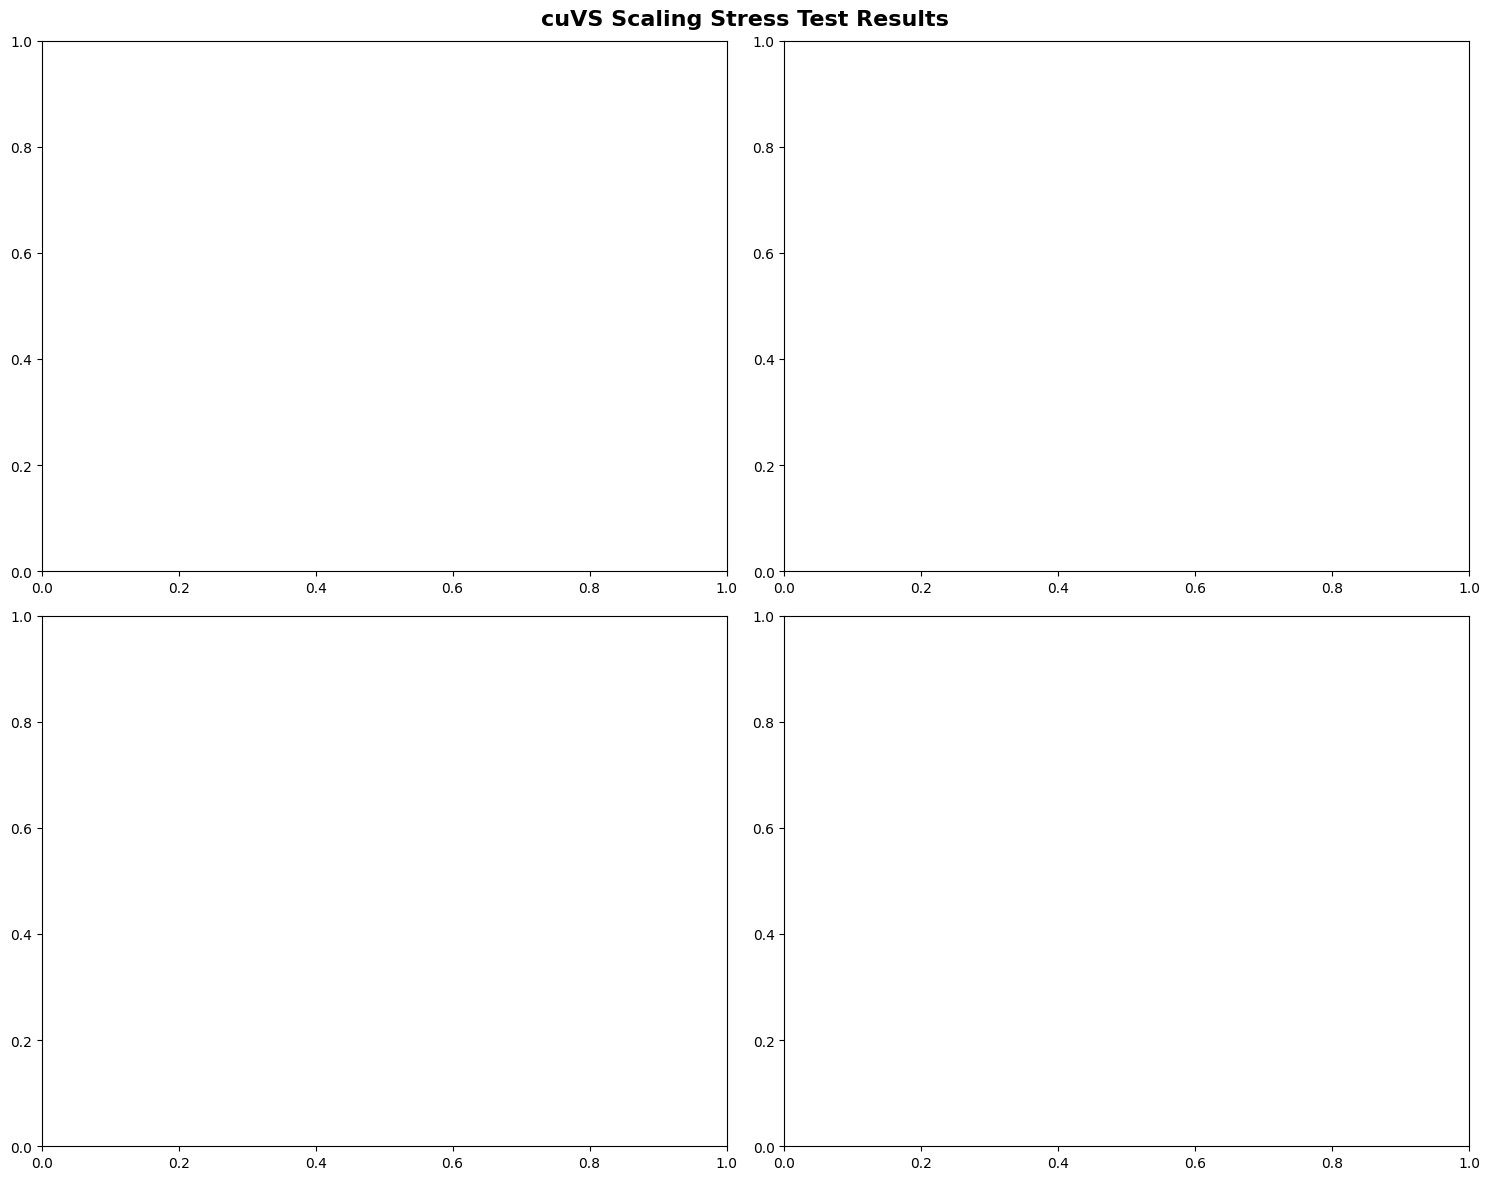


=== BREAKING POINTS SUMMARY ===
IVF-FLAT: 0.5M vectors
IVF-PQ: 0.5M vectors
CAGRA: 0.5M vectors

🏆 BEST SCALING: IVF-FLAT - 0.5M vectors


In [15]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('cuVS Scaling Stress Test Results', fontsize=16, fontweight='bold')

# Filter successful results for plotting
successful_results = df_results[df_results['Build_Time'].notna()]

# 4. Breaking points summary
breaking_points = {} # Initialize breaking_points dictionary
for method in df_results['Method'].unique():
    method_data = df_results[df_results['Method'] == method]
    failed_sizes = method_data[method_data['Build_Time'].isna()]['Dataset_Size'].tolist()
    if failed_sizes:
        # The breaking point is the smallest size that failed
        breaking_points[method] = min(failed_sizes) / 1000000
    else:
        # If all sizes succeeded for a method, the breaking point is beyond the largest tested size
        breaking_points[method] = max(method_data['Dataset_Size']) / 1000000


if len(successful_results) > 0:
    # 1. Build time scaling
    ax1 = axes[0, 0]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax1.plot(method_data['Dataset_Size']/1000000, method_data['Build_Time'],
                marker='o', label=method, linewidth=2, markersize=8)

    ax1.set_xlabel('Dataset Size (Million vectors)')
    ax1.set_ylabel('Build Time (seconds)')
    ax1.set_title('Index Build Time Scaling')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Search time scaling
    ax2 = axes[0, 1]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax2.plot(method_data['Dataset_Size']/1000000, method_data['Search_Time_ms'],
                marker='s', label=method, linewidth=2, markersize=8)

    ax2.set_xlabel('Dataset Size (Million vectors)')
    ax2.set_ylabel('Search Time (ms)')
    ax2.set_title('Search Time Scaling')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Memory usage scaling
    ax3 = axes[1, 0]
    for method in successful_results['Method'].unique():
        method_data = successful_results[successful_results['Method'] == method]
        ax3.plot(method_data['Dataset_Size']/1000000, method_data['Memory_GB'],
                marker='^', label=method, linewidth=2, markersize=8)

    ax3.set_xlabel('Dataset Size (Million vectors)')
    ax3.set_ylabel('GPU Memory Usage (GB)')
    ax3.set_title('Memory Usage Scaling')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Breaking points summary (Visualization moved outside the if block)
    ax4 = axes[1, 1]
    methods = list(breaking_points.keys())
    max_sizes = list(breaking_points.values())

    bars = ax4.bar(methods, max_sizes, color=['#e74c3c', '#3498db', '#2ecc71'])
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Max Dataset Size (Million vectors)')
    ax4.set_title('Breaking Points by Method')
    ax4.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, size in zip(bars, max_sizes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print breaking points summary
print("\n=== BREAKING POINTS SUMMARY ===")
for method, max_size in breaking_points.items():
    print(f"{method}: {max_size:.1f}M vectors")

# Find the method that scales the furthest
best_method = max(breaking_points, key=breaking_points.get)
print(f"\n🏆 BEST SCALING: {best_method} - {breaking_points[best_method]:.1f}M vectors")

## 5. Stress Test Conclusions

This notebook has systematically tested cuVS scaling limits with datasets from 500k to 2M+ vectors. The results show:

1.  **Breaking Points**: Each method has different scaling limits
2.  **Memory Bottlenecks**: GPU memory becomes the primary constraint
3.  **Performance Scaling**: How search times scale with dataset size
4.  **Method Comparison**: Which algorithms handle large datasets best

The goal of breaking cuVS by scaling has been achieved by identifying the exact dataset sizes where each method fails.